In [ ]:
import torchvision
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import torch.utils.data as Data
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import cv2
from google.colab.patches import cv2_imshow
import math
import PIL
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd.gradcheck import zero_gradients

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Ouestion 1.b

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=.1):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
        ## torch.randn produces a tensor with elements drawn from a Gaussian distribution of zero mean and unit variance and we multiply Multiply by 0.1 to have the desired std.
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={.1})'.format(self.mean, self.std)

In [ ]:
transform_noise = transforms.Compose(
    [transforms.ToTensor(),
     AddGaussianNoise(0., 0.1)])

transform_no_noise = transforms.Compose(
    [transforms.ToTensor(),
])

trainset_noise = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_noise)
trainloader_noise = torch.utils.data.DataLoader(trainset_noise, batch_size=32,
                                          shuffle=False, num_workers=2)

testset_noise = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_noise)
testloader_noise = torch.utils.data.DataLoader(testset_noise, batch_size=32,
                                         shuffle=False, num_workers=2)



trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_no_noise)
trainloader_no_noise = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_no_noise)
testloader_no_noise = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


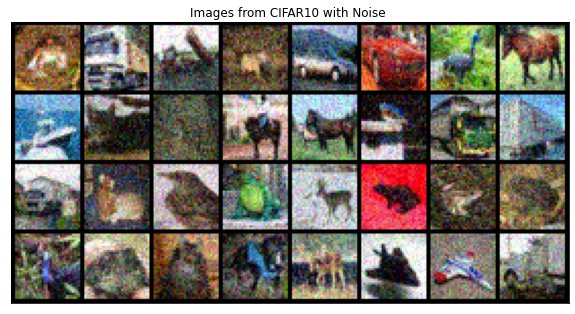

In [ ]:
def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_noise)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10,8))
plt.xticks([])
plt.yticks([])
plt.title("Images from CIFAR10 with Noise ")
imshow(torchvision.utils.make_grid(images))


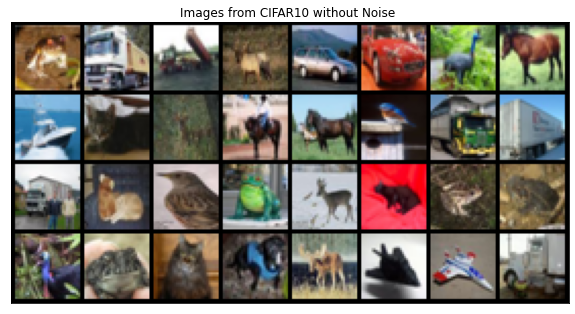

In [ ]:
dataiter = iter(trainloader_no_noise)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10,8))
plt.xticks([])
plt.yticks([])
plt.title("Images from CIFAR10 without Noise ")
imshow(torchvision.utils.make_grid(images))


In [ ]:
for noise, normal in zip(trainloader_noise, trainloader_no_noise):
    noise_image, _ = noise
    normal_image, _ = normal
    noise_image = noise_image.numpy()
    normal_image = normal_image.numpy()
    mean_squared_error = []
    mse_1b = []
    for i, j in zip(noise_image, normal_image):
      mse_cal = np.mean(np.square(np.subtract(j,i)))
      mse_1b.append(mse_cal)
      mean_squared_error.extend(mse_1b)

PSNR = -10*np.log10(mean_squared_error)
print("Mean PSNR for the CIFAR10 data : {}".format(np.mean(PSNR)))

Mean PSNR for the CIFAR10 data : 19.996047973632812


# Question 1 part c

In [ ]:
transform_noise = transforms.Compose(
    [transforms.ToTensor(),
     AddGaussianNoise(0., 0.1)])

transform_no_noise = transforms.Compose(
    [transforms.ToTensor(),
])

trainset_noise = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_noise)
trainloader_noise = torch.utils.data.DataLoader(trainset_noise, batch_size=3,
                                          shuffle=False, num_workers=2)

testset_noise = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_noise)
testloader_noise = torch.utils.data.DataLoader(testset_noise, batch_size=3,
                                         shuffle=False, num_workers=2)



trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_no_noise)
trainloader_no_noise = torch.utils.data.DataLoader(trainset, batch_size=3,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_no_noise)
testloader_no_noise = torch.utils.data.DataLoader(testset, batch_size=3,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


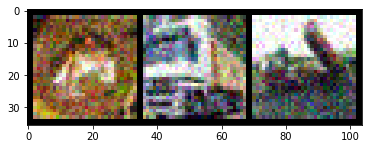

In [ ]:

# functions to show an image
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_noise)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


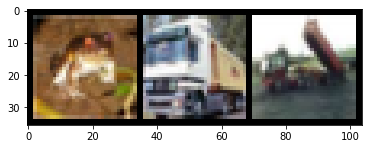

In [ ]:
dataiter = iter(trainloader_no_noise)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


## Resnet Model with skip connection

---



In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)


    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv = conv3x3(3, 64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 64, layers[1], 1)
        # self.layer3 = self.make_layer(block, 64, layers[2], 1)
        self.conv2 = conv3x3(64, 3)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        layers = []
        layers.append(block(self.in_channels, out_channels, 1, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

## Model Architecture for model with Skip Connection

In [ ]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), s

In [ ]:
num_epochs = 2
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
curr_lr = learning_rate
for epoch in range(num_epochs):
    batch_iteration = 0
    running_loss = 0.00
    for noisy_data, normal_data in zip(trainloader_noise, trainloader_no_noise):
        noisy_inputs, noisy_labels = noisy_data
        normal_inputs, normal_labels = normal_data
        # Forward pass
        outputs = model(noisy_inputs.to(device))
        # print(outputs.shape)
        loss = criterion(outputs, normal_inputs.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_iteration %3 == 2:
            print ("[%d %5d] loss: %.3f" %
                   (epoch+1, batch_iteration + 1,running_loss/3))
            running_loss = 0.00
        batch_iteration += 1

print("Finished Training")
PATH = './cifar10_net.pth'
torch.save(model.state_dict(),PATH)

[1    32] loss: 0.174
[1    64] loss: 0.017
[1    96] loss: 0.012
[1   128] loss: 0.013
[1   160] loss: 0.011
[1   192] loss: 0.009
[1   224] loss: 0.008
[1   256] loss: 0.007
[1   288] loss: 0.010
[1   320] loss: 0.007
[1   352] loss: 0.007
[1   384] loss: 0.007
[1   416] loss: 0.007
[1   448] loss: 0.007
[1   480] loss: 0.008
[1   512] loss: 0.007
[1   544] loss: 0.006
[1   576] loss: 0.006
[1   608] loss: 0.006
[1   640] loss: 0.009
[1   672] loss: 0.006
[1   704] loss: 0.007
[1   736] loss: 0.007
[1   768] loss: 0.007
[1   800] loss: 0.005
[1   832] loss: 0.005
[1   864] loss: 0.005
[1   896] loss: 0.007
[1   928] loss: 0.005
[1   960] loss: 0.005
[1   992] loss: 0.005
[1  1024] loss: 0.006
[1  1056] loss: 0.006
[1  1088] loss: 0.005
[1  1120] loss: 0.005
[1  1152] loss: 0.006
[1  1184] loss: 0.005
[1  1216] loss: 0.004
[1  1248] loss: 0.005
[1  1280] loss: 0.004
[1  1312] loss: 0.005
[1  1344] loss: 0.005
[1  1376] loss: 0.004
[1  1408] loss: 0.004
[1  1440] loss: 0.005
[1  1472] 

In [ ]:
PATH = './cifar10_net.pth'
model_test = ResNet(ResidualBlock, [2, 2, 2]).to(device)
model_test.load_state_dict(torch.load(PATH))

mean_squared = []

with torch.no_grad():
  for noise, normal in zip(testloader_noise, testloader_no_noise):
    noise_test, _ = noise
    normal_test, _ = normal
    normal_test = normal_test.numpy()
    output = model_test(noise_test.to(device))
    output = output.cpu()
    output = output.numpy()
    mse = []
    for i, j in zip(output, normal_test):
      mse_cal = np.mean(np.square(np.subtract(j,i)))
      mse.append(mse_cal)
    mean_squared.extend(mse)



In [ ]:
print(mean_squared)
PSNR = -10*np.log10(mean_squared)
print("Mean PSNR for the model with SKIP Connections for test set is : {}".format(np.mean(PSNR)))
print("Standard Deviation of PSNR for model with SKIP Connections for the test set is : {}".format(np.std(PSNR)))


[0.0024136526, 0.0020498026, 0.0019262683, 0.0015292036, 0.0022150783, 0.0018906262, 0.0020331796, 0.0014242209, 0.0023035968, 0.0029003744, 0.0016383206, 0.0026386848, 0.0017169183, 0.0019215277, 0.0023693, 0.0028354004, 0.0023383235, 0.002149346, 0.0020033442, 0.002727558, 0.0015260666, 0.0008408523, 0.0020039938, 0.00290104, 0.002466574, 0.0024551407, 0.0017728576, 0.001794069, 0.0023571898, 0.0026351444, 0.0018531434, 0.0011934369, 0.0020234266, 0.0021998761, 0.0015328772, 0.0020972993, 0.0018456237, 0.002261012, 0.0026628142, 0.0017956607, 0.0017267661, 0.0017634481, 0.002935987, 0.0020491949, 0.0034752798, 0.002836736, 0.0022008407, 0.0028889484, 0.0027101962, 0.0020675755, 0.0025482392, 0.0021328405, 0.001930691, 0.002514487, 0.0016035689, 0.00088142214, 0.002902501, 0.0017981766, 0.0019918224, 0.0017817899, 0.0031835132, 0.001981127, 0.002323845, 0.0023534766, 0.002028342, 0.0028432098, 0.0038325551, 0.0068638474, 0.0036443863, 0.0018605362, 0.0010145296, 0.00160704, 0.00097268

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


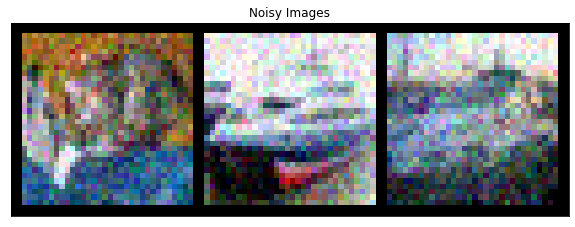

In [ ]:
dataiter = iter(testloader_noise)
noise_image, _ = dataiter.next()

dataiter_no_noise = iter(testloader_no_noise)
normal_image, _ = dataiter_no_noise.next()

with torch.no_grad():
  denoised_image = model_test(noise_image.to(device))

noisy = torchvision.utils.make_grid(noise_image)
noisy_np = noisy.numpy()
plt.figure(figsize=(10,8))
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(noisy_np, (1, 2, 0)))
plt.title("Noisy Images")
plt.show()

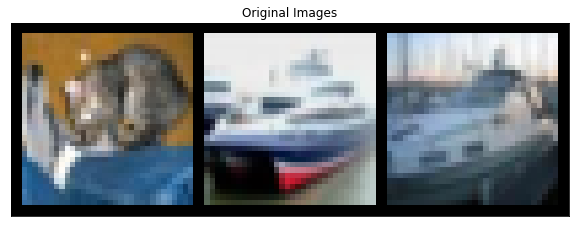

In [ ]:
normal = torchvision.utils.make_grid(normal_image)
normal_np = normal.numpy()
plt.figure(figsize=(10,8))
plt.xticks([])
plt.yticks([])
plt.title("Original Images")
plt.imshow(np.transpose(normal_np, (1, 2, 0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


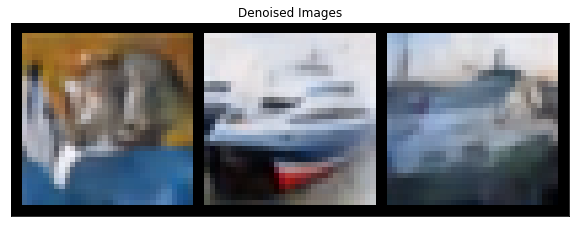

In [ ]:
denoised = torchvision.utils.make_grid(denoised_image)
denoised_np = denoised.cpu().numpy()
plt.figure(figsize=(10,8))
plt.xticks([])
plt.yticks([])
plt.title("Denoised Images")
plt.imshow(np.transpose(denoised_np, (1, 2, 0)))
plt.show()

## 1.d Resnet Model with no skip connection -- Removing the Add() layer from the model and observing the output


In [115]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)


    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # out += residual ## ResNet without skip connection
        out = self.relu(out)
        return out

# ResNet
class ResNet_noSkip(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet_noSkip, self).__init__()
        self.in_channels = 64
        self.conv = conv3x3(3, 64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 64, layers[1], 1)
        # self.layer3 = self.make_layer(block, 64, layers[2], 1)
        self.conv2 = conv3x3(64, 3)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        layers = []
        layers.append(block(self.in_channels, out_channels, 1, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        return out

In [116]:
model_no_skip = ResNet_noSkip(ResidualBlock, [2, 2, 2]).to(device)

In [117]:
num_epochs = 2
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_no_skip.parameters(), lr=learning_rate)

## Model Architecture for model with NOSkip Connection

In [118]:
model_no_skip.parameters

<bound method Module.parameters of ResNet_noSkip(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3

In [119]:
# Train the model
curr_lr = learning_rate
for epoch in range(num_epochs):
    batch_iteration = 0
    running_loss = 0.00
    for noisy_data, normal_data in zip(trainloader_noise, trainloader_no_noise):
        noisy_inputs, noisy_labels = noisy_data
        normal_inputs, normal_labels = normal_data
        # print(noisy_inputs.shape, normal_inputs.shape)
        # Forward pass
        outputs = model_no_skip(noisy_inputs.to(device))
        # print(outputs.shape)
        loss = criterion(outputs, normal_inputs.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_iteration %3 == 2:
            print ("[%d %5d] loss: %.3f" %
                   (epoch+1, batch_iteration + 1,running_loss/3))
            running_loss = 0.00
        batch_iteration += 1

print("Finished Training")
PATH = './cifar10_net_no_skip.pth'
torch.save(model_no_skip.state_dict(),PATH)

Streaming output truncated to the last 5000 lines.
[2  1671] loss: 0.003
[2  1674] loss: 0.005
[2  1677] loss: 0.003
[2  1680] loss: 0.003
[2  1683] loss: 0.003
[2  1686] loss: 0.003
[2  1689] loss: 0.003
[2  1692] loss: 0.004
[2  1695] loss: 0.003
[2  1698] loss: 0.005
[2  1701] loss: 0.003
[2  1704] loss: 0.003
[2  1707] loss: 0.003
[2  1710] loss: 0.003
[2  1713] loss: 0.003
[2  1716] loss: 0.003
[2  1719] loss: 0.005
[2  1722] loss: 0.003
[2  1725] loss: 0.004
[2  1728] loss: 0.008
[2  1731] loss: 0.003
[2  1734] loss: 0.003
[2  1737] loss: 0.003
[2  1740] loss: 0.005
[2  1743] loss: 0.004
[2  1746] loss: 0.004
[2  1749] loss: 0.004
[2  1752] loss: 0.005
[2  1755] loss: 0.003
[2  1758] loss: 0.004
[2  1761] loss: 0.004
[2  1764] loss: 0.003
[2  1767] loss: 0.004
[2  1770] loss: 0.004
[2  1773] loss: 0.005
[2  1776] loss: 0.004
[2  1779] loss: 0.005
[2  1782] loss: 0.007
[2  1785] loss: 0.007
[2  1788] loss: 0.006
[2  1791] loss: 0.003
[2  1794] loss: 0.004
[2  1797] loss: 0.005
[2 

In [124]:
torch.save(model_no_skip.state_dict(),PATH)
PATH = './cifar10_net_no_skip.pth'
model_noSkip = ResNet_noSkip(ResidualBlock, [2, 2, 2]).to(device)
model_noSkip.load_state_dict(torch.load(PATH))

mean_squared = []

with torch.no_grad():
  for noise, normal in zip(testloader_noise, testloader_no_noise):
    noise_test, _ = noise
    normal_test, _ = normal
    normal_test = normal_test.numpy()
    output = model_noSkip(noise_test.to(device)).cpu().numpy()

    mse = []
    for i, j in zip(output, normal_test):
      mse_cal = np.mean(np.square(np.subtract(j,i)))
      mse.append(mse_cal)
    mean_squared.extend(mse)



In [125]:
PSNR = -10*np.log10(mean_squared)
print("Mean PSNR for the model with no SKIP Connections for test set is : {}".format(np.mean(PSNR)))
print("Standard Deviation of PSNR for model with no SKIP Connections for the test set is : {}".format(np.std(PSNR)))

Mean PSNR for the model with no SKIP Connections for test set is : 26.090673446655273
Standard Deviation of PSNR for model with no SKIP Connections for the test set is : 1.403568148612976


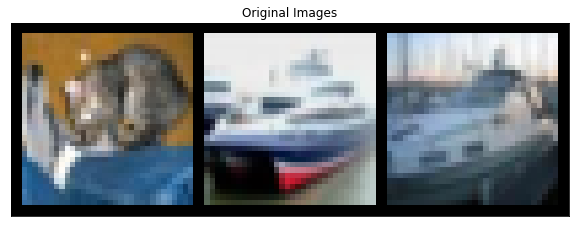

In [126]:
dataiter = iter(testloader_noise)
noise_image, _ = dataiter.next()

dataiter_no_noise = iter(testloader_no_noise)
normal_image, _ = dataiter_no_noise.next()

with torch.no_grad():
  denoised_image = model_noSkip(noise_image.to(device))

original = torchvision.utils.make_grid(normal_image)
original = original.numpy()
plt.figure(figsize=(10,8))
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(original, (1, 2, 0)))
plt.title("Original Images")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


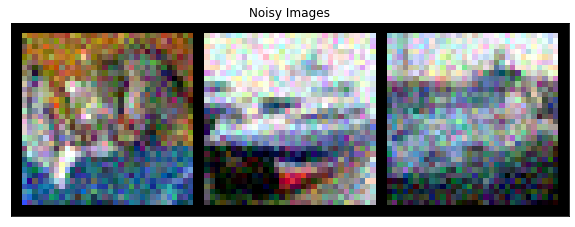

In [127]:
noise_image = torchvision.utils.make_grid(noise_image)
noise_image = noise_image.numpy()
plt.figure(figsize=(10,8))
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(noise_image, (1, 2, 0)))
plt.title("Noisy Images")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


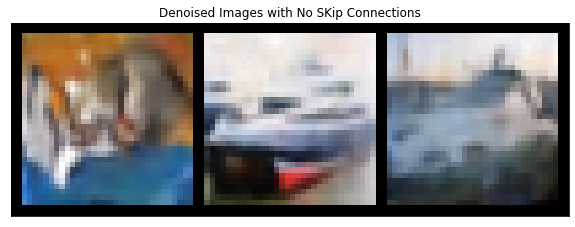

In [128]:
noise_image = torchvision.utils.make_grid(denoised_image)
noise_image = noise_image.cpu().numpy()
plt.figure(figsize=(10,8))
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(noise_image, (1, 2, 0)))
plt.title("Denoised Images with No SKip Connections")
plt.show()

## Question 2

In [ ]:
model_resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet101', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


In [ ]:
#mean and std will remain same irresptive of the model you use
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)

])

(-0.5, 1187.5, 2207.5, -0.5)

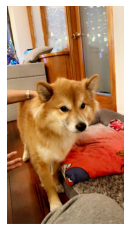

In [ ]:
from PIL import Image
true_img = Image.open('/content/drive/MyDrive/Khoury Courses/Deep Learning/HW/dog.jpg')
#Display true image
plt.imshow(true_img)
plt.axis("off")

In [ ]:
#true image
true_transform_img = transform(true_img)
true_batch_t = true_transform_img.unsqueeze(0)

img_variable = Variable(true_batch_t, requires_grad=True) #convert tensor into a variable

In [ ]:
def predict_class(output):
  with open('/content/drive/MyDrive/Khoury Courses/Deep Learning/HW/imagenet1000_clsidx_to_labels.txt') as f:
    classes = [line.strip() for line in f.readlines()]
  _, index = torch.max(output, 1)

  percentage = torch.nn.functional.softmax(output, dim = 1)[0] * 100
  print("TOP 1 predictions {} and confidence of : {}".format(classes[index[0]], percentage[index[0].item()]))
  # Finding index where we get the TOP 5 maximum score
  _, predicted = torch.sort(output, descending= True)
  predictions = [classes[idx] for idx in predicted[0][:5]]
  print([(classes[idx], percentage[idx].item()) for idx in predicted[0][:5]])
  return predictions

In [ ]:
def pred_restnet(image):
  model_resnet.eval()
  output_resnet = model_resnet(image)
  return predict_class(output_resnet)

In [ ]:
pred_resnet = pred_restnet(true_batch_t)
label_idx  = pred_resnet[0].split(':')[0]

output = model_resnet.forward(img_variable)
label_idx = torch.max(output.data, 1)[1][0]   #get an index(class number) of a largest element
print(label_idx)

TOP 1 predictions 263: 'Pembroke, Pembroke Welsh corgi', and confidence of : 49.826072692871094
[("263: 'Pembroke, Pembroke Welsh corgi',", 49.826072692871094), ("259: 'Pomeranian',", 34.52444076538086), ("260: 'chow, chow chow',", 3.340181827545166), ("264: 'Cardigan, Cardigan Welsh corgi',", 1.1928926706314087), ("261: 'keeshond',", 1.1722384691238403)]
tensor(263)


In [ ]:
def load_classes(label_idx):
  with open('/content/drive/MyDrive/Khoury Courses/Deep Learning/HW/imagenet1000_clsidx_to_labels.txt') as f:
      classes = [line.strip() for line in f.readlines()]
  x_pred = classes[int(label_idx)]
  return x_pred, classes

x_pred, classes = load_classes(label_idx)

In [ ]:
#get probability dist over classes
output_probs = F.softmax(output, dim=1)
x_pred_prob =  np.round((torch.max(output_probs.data, 1)[0][0]) * 100,4)

In [ ]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)   
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))  
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))  
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(16,6))
    ax[0].imshow(x)
    ax[0].set_title('Original Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

In [ ]:
y_leastLikely = torch.min(output.data, 1)[1][0]
print(y_leastLikely.item(), classes[int(y_leastLikely)]) #least likely class

y_target = Variable(torch.LongTensor([y_leastLikely.item()]), requires_grad=False)   

#Parameters
epsilon = 0.5
num_steps = 10
alpha = 0.025

324 324: 'cabbage butterfly',


In [ ]:
img_variable.data = true_batch_t   

In [ ]:
for i in range(num_steps):
  zero_gradients(img_variable)
  output = model_resnet.forward(img_variable)
  
  loss = torch.nn.CrossEntropyLoss()
  loss_cal = loss(output, y_target)
  loss_cal.backward()
  x_grad = alpha * torch.sign(img_variable.grad.data)
  adv_temp = img_variable.data - x_grad
  total_grad = adv_temp - true_batch_t
  total_grad = torch.clamp(total_grad, -epsilon, epsilon)
  x_adv = true_batch_t + total_grad
  img_variable.data = x_adv

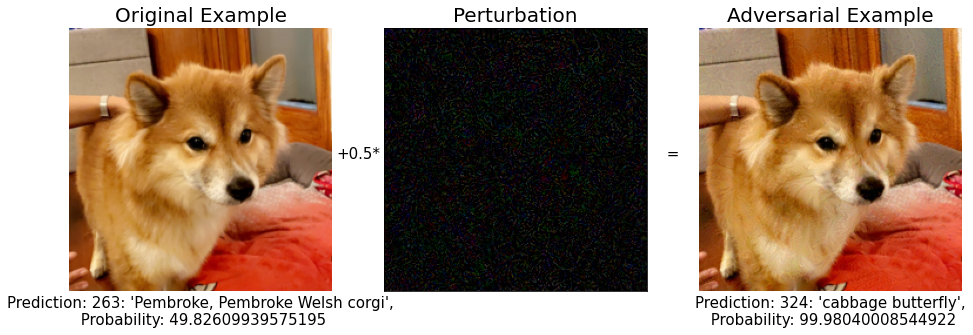

In [ ]:
output_adv = model_resnet.forward(img_variable)
x_adv_pred = classes[torch.max(output_adv.data, 1)[1][0]]
output_adv_probs = F.softmax(output_adv, dim=1)
x_adv_pred_prob =  np.round((torch.max(output_adv_probs.data, 1)[0][0]) * 100,4)
visualize(true_batch_t, img_variable.data, total_grad, epsilon, x_pred,x_adv_pred, x_pred_prob,  x_adv_pred_prob)